# Requirements & Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gdal
!pip install rasterio
!pip install geopandas
!pip install osgeo
!pip install patchify

In [ ]:
import rasterio
from rasterio.merge import merge
import geopandas as gpd
from osgeo import gdal, osr, ogr
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage
from skimage import exposure
import patchify
from patchify import patchify, unpatchify
import tifffile as tiff
from rasterio.enums import ColorInterp
from rasterio.windows import Window
from skimage.measure import block_reduce
from rasterio import windows
import rasterio.plot as rp
import rasterio.features
import random

# A) Preprocess Sentinel-2 imagery

This section performs the following tasks:

1.   Reproject bands 2, 3 and 4 to EPSG 4326
2.   Create true-color RGB image by combining bands
3.   Subset satellite image to study area
4.   Normalize image using histogram equalization
5.   Visualize the reprojected & normalized satellite image
6.   Save reprojected & normalized satellite image on disk

## 1. Define function for pre-processing 

In [ ]:
def preprocess_sentinel(bands, folder,
                        west, south, east, north):
  
  base_path = '../../data/sentinel2/'
  suffix = '_10m.jp2'

  folder_path = base_path + folder
  subfolders = ['Step1', 'Step2', 'Step3', 'Step4']
  for subfolder in subfolders:
      subfolder_path = base_path + folder + '/' + subfolder
      if not os.path.exists(subfolder_path):
          os.makedirs(subfolder_path)

  b2_source = base_path + folder + '/' + bands + '_B02' + suffix
  b3_source = base_path + folder + '/' + bands + '_B03' + suffix
  b4_source = base_path + folder + '/' + bands + '_B04' + suffix

  if not os.path.exists(b2_source):
    raise ValueError(f"B2 source file '{b2_source}' does not exist")

  if not os.path.exists(b3_source):
    raise ValueError(f"B3 source file '{b3_source}' does not exist")
  
  if not os.path.exists(b4_source):
    raise ValueError(f"B4 source file '{b4_source}' does not exist")

  b2_output = base_path + folder + '/Step1/B02_10m_EPSG4326.tif'
  b3_output = base_path + folder + '/Step1/B03_10m_EPSG4326.tif'
  b4_output = base_path + folder + '/Step1/B04_10m_EPSG4326.tif'

  RGB_EPSG4326 = base_path + folder + '/Step2/RGB_EPSG4326.tif'
  RGB_EPSG4326_cropped = base_path + folder + '/Step3/RGB_EPSG4326_cropped.tif'
  RGB_EPSG4326_cropped_normalized = base_path + folder + '/Step4/RGB_EPSG4326_cropped_normalized.tif'

  # Reproject bands
  target_crs = "EPSG:4326"
  gdal.Warp(b2_output, b2_source, dstSRS=target_crs)
  gdal.Warp(b3_output, b3_source, dstSRS=target_crs)
  gdal.Warp(b4_output, b4_source, dstSRS=target_crs)

  # Create RGB image
  blue_band = rasterio.open(b2_output)
  green_band = rasterio.open(b3_output)
  red_band = rasterio.open(b4_output)

  blue = blue_band.read(1)
  green = green_band.read(1)
  red = red_band.read(1)

  with rasterio.open(RGB_EPSG4326, 'w', driver='GTiff', width=blue_band.width, height=blue_band.height,
                   count=3, dtype='float32', crs=blue_band.crs, transform=blue_band.transform) as dst:
    dst.write(red, 1)
    dst.write(green, 2)
    dst.write(blue, 3)

  # Crop RGB image
  with rasterio.open(RGB_EPSG4326) as src:
      # Calculate the window to read
      window = src.window(west, south, east, north)

      # Read the data from the window
      data = src.read(window=window)

      # Update the metadata of the output file
      meta = src.meta.copy()
      meta.update({
          'height': window.height,
          'width': window.width,
          'transform': src.window_transform(window)
      })

      # Write the cropped data to the output file
      with rasterio.open(RGB_EPSG4326_cropped, 'w', **meta) as dst:
          dst.write(data)
  
  # Normalize the cropped RGB image using histogram equalization

  with rasterio.open(RGB_EPSG4326_cropped) as src:
      profile = src.profile
      # Read the data from the file
      data = src.read().transpose((0, 1, 2))
      # Split the data into individual color channels
      blue, green, red = data

  blue = exposure.equalize_hist(blue)
  green = exposure.equalize_hist(green)
  red = exposure.equalize_hist(red)

  equalized_data = np.dstack((blue, green, red))

  profile.update(count=3, dtype=equalized_data.dtype)
  with rasterio.open(RGB_EPSG4326_cropped_normalized, 'w', **profile) as dst:
      dst.write(equalized_data.transpose((2, 0, 1)))

  img_rgb = gdal.Open(RGB_EPSG4326_cropped_normalized)
  gdalinfo_rgb = gdal.Info(img_rgb)
  print(gdalinfo_rgb)

  # Visualize the normalized and cropped RGB image

  with rasterio.open(RGB_EPSG4326_cropped_normalized) as src:
      # Read the data from the file
      data = src.read().transpose((1, 2, 0))
      # Plot the data using Matplotlib
      plt.imshow(data)
      plt.show()

## 2. Run function on Sentinel-2 imagery

Driver: GTiff/GeoTIFF
Files: /content/drive/MyDrive/Data/1_SatelliteImagery/Vinnytsia/v5/Step4/RGB_EPSG4326_cropped_normalized.tif
Size is 5780, 2233
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (28.161757000000001,49.359606999999990)
Pixel Size = (0.000114619918697,-0.000114619918697)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (  28.1617570,  49.3596070) ( 28d 9'42.33"E, 49d21'34.59"N)
Lower Left  (  28.

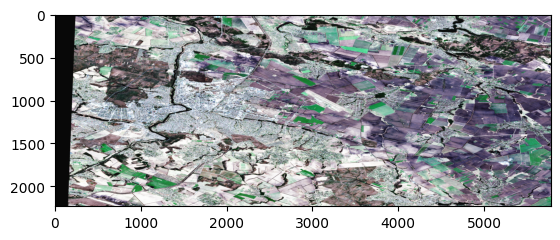

In [ ]:
bands = 'S2B_MSIL2A_20210410T090549_N0300_R050_T35UPQ_20210410T120243.SAFE/GRANULE/L2A_T35UPQ_A021383_20210410T090934/IMG_DATA/R10m/T35UPQ_20210410T090549'
folder = 'vinnytsia'
west, south, east, north = 28.161757, 49.103581, 28.824370, 49.359607 # Vinnytsia
preprocess_sentinel(bands, folder, west, south, east, north)

# B) Preprocess LandScan data

## Define function for pre-processing

In [ ]:
def preprocess_landscan_log(resolution,
                        west, south, east, north):

    base_path = '../../data/landscanHD/'
    aggregatedUKR = base_path + resolution + '/aggregated_UKR_population_data.tif'
    reducedaggregatedUKR = base_path + resolution + '/aggregated_UKR_population_data_reduced.tif'
    reducedaggregated_Kyiv = base_path + resolution + '/aggregated_UKR_population_data_reduced_Vinnytsia_vf_log.tif'

    # Load the population raster data
    with rasterio.open("../../data/landscanHD/landscan-hd-ukraine-v1.tif") as src:
        population_data = src.read(1)

    # Take the logarithm of the population data
    population_data = np.where(population_data > 0, np.log10(population_data), 0)

    # Aggregate the population data by a factor of 10
    aggregated_population_data = block_reduce(population_data, block_size=(10, 10), func=np.sum)

    # Save the aggregated population data
    with rasterio.open(aggregatedUKR, "w", **src.meta) as dst:
        dst.write(aggregated_population_data, 1)

    # Open the aggregated population data
    with rasterio.open(aggregatedUKR) as src:

        # Specify the reduction factor
        factor = (10, 10)

        # Apply the block reduction
        data = src.read(1)
        data_reduced = block_reduce(data, factor, np.mean)

        # Create a new profile for the output raster
        profile = src.profile
        profile.update({
            'width': data_reduced.shape[1],
            'height': data_reduced.shape[0],
            'transform': src.transform * src.transform.scale(factor[1], factor[0])
        })

        # Write the reduced raster to disk
        with rasterio.open(reducedaggregatedUKR, 'w', **profile) as dst:
            dst.write(data_reduced, 1)

    # open the aggregated population data file
    with rasterio.open(reducedaggregatedUKR) as src:

        # get the window of the data that intersects with the specified bounding box
        window = src.window(west, south, east, north)

        # read the data within the window
        data = src.read(1, window=window)

        # get the transform for the new, cropped dataset
        transform = src.window_transform(window)

        # update the metadata for the cropped dataset
        meta = src.meta.copy()
        meta.update({
            'height': window.height,
            'width': window.width,
            'transform': transform})

    # write the cropped data to a new file
    with rasterio.open(reducedaggregated_Kyiv, 'w', **meta) as dst:
        dst.write(data, 1)

    agg_pop_reduced_kyiv = gdal.Open(reducedaggregated_Kyiv)
    gdalinfo_agg_pop_reduced_kyiv = gdal.Info(agg_pop_reduced_kyiv)
    print(gdalinfo_agg_pop_reduced_kyiv)

    # Open the cropped raster data
    with rasterio.open(reducedaggregated_Kyiv) as src:
        # Print the CRS and spatial resolution
        print(src.crs)
        print(src.res)

    # Open the cropped raster data
    with rasterio.open(reducedaggregated_Kyiv) as src:
        # Create the color gradient from blue to red
        cmap = plt.cm.get_cmap('coolwarm')
        # Set the nodata value to be transparent
        cmap.set_bad(alpha=0)
        # Plot the raster data
        rp.show(src, cmap=cmap)

## Run function on Vinnytsia city area

<ipython-input-71-90b056812f0a>:14: RuntimeWarning: divide by zero encountered in log10
  population_data = np.where(population_data > 0, np.log10(population_data), 0)
<ipython-input-71-90b056812f0a>:14: RuntimeWarning: invalid value encountered in log10
  population_data = np.where(population_data > 0, np.log10(population_data), 0)


Driver: GTiff/GeoTIFF
Files: /content/drive/MyDrive/Data/2_PopulationData/Ukraine/30arcsec/aggregated_UKR_population_data_reduced_Vinnytsia_vf_log.tif
Size is 60, 25
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (28.219757000000001,49.338994000000000)
Pixel Size = (0.008333333330000,-0.008333333330000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  28.2197570,  49.3389940) ( 28d13'11.13"E, 49d20'20.38"N)
Low

<ipython-input-71-90b056812f0a>:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


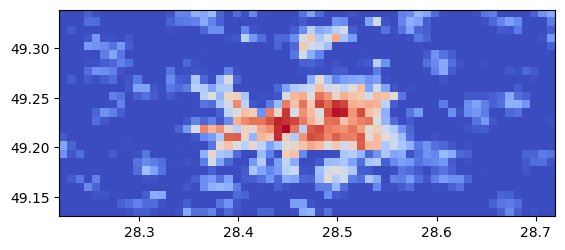

In [ ]:
resolution = '30arcsec'
west, south, east, north = 28.219757, 49.125567, 28.727875, 49.338994 # Vinnytsia

preprocess_landscan_log(resolution, west, south, east, north)

# C) Extract corresponding patches

For each grid in the population data, extract a corresponding satellite image patch from the subsetted and reprojected Sentinel-2 imagery. The size of each patch should be 90 x 90 pixels, which corresponds to 900m x 900m at a resolution of 10m.

## 1. Split population raster into pixels


In [ ]:
# Load the aggregated population data
with rasterio.open('../../data/landscanHD/30arcsec/aggregated_UKR_population_data_reduced_Vinnytsia_vf_log.tif') as pop_data:
    pop = pop_data.read(1)

# Reshape the population data into individual pixels
pop_pixels = pop.flatten()

## 2. Extract satellite image patches for each pixel in  population data

In [ ]:
# Load the satellite imagery
with rasterio.open('../../data/sentinel2/vinnytsia/Step4/RGB_EPSG4326_cropped_normalized.tif') as sat_data:
    sat = sat_data.read()
    transform = sat_data.transform
    width, height = sat_data.width, sat_data.height

# Define the size of the satellite image patches
patch_size = 90

# Initialize an empty array to store the satellite image patches
sat_patches = np.empty((pop.size, patch_size, patch_size, 3))

# Extract the satellite image patches
for i, (row, col) in enumerate(np.ndindex(pop.shape)):
    # Calculate the exact coordinates of the upper-left and lower-right corners of the population grid in the raster
    x, y = transform * (col*30, row*30)
    x2, y2 = transform * ((col+1)*30, (row+1)*30)

    # Check if the coordinates are within the bounds of the raster
    if x >= 0 and y >= 0 and x2 < width and y2 < height:
        # Calculate the row and column indices of the window in the satellite image
        start_col, start_row = map(int, rasterio.transform.rowcol(transform, x, y))
        end_col, end_row = map(int, rasterio.transform.rowcol(transform, x2, y2))

        # Calculate the window of the satellite image patch
        window = rasterio.windows.Window(start_col, start_row, end_col - start_col, end_row - start_row)

        # Extract the satellite image patch
        sat_patch = sat[:, window.row_off:window.row_off+patch_size, window.col_off:window.col_off+patch_size]

        # Transpose the dimensions of the satellite image patch to match the ResNet model's input shape
        sat_patch = np.transpose(sat_patch, (1, 2, 0))

        # Store the satellite image patch in the array
        sat_patches[i] = sat_patch

## 3. Save preprocessed patches as separate files

In [ ]:
# Create directories for the preprocessed data
os.makedirs('../../data/PatchesTransferability/sat_patches', exist_ok=True)
os.makedirs('../../data/PatchesTransferability/pop_patches', exist_ok=True)

# Save the satellite image patches
for i, patch in enumerate(sat_patches):
    file_name = f'vinnytsia_sat_patch_{i}.npy'
    file_path = os.path.join('../../data/PatchesTransferability/sat_patches', file_name)
    np.save(file_path, patch)

# Save the population patches
for i, pop_pixel in enumerate(pop_pixels):
    file_name = f'vinnytsia_pop_patch_{i}.npy'
    file_path = os.path.join('../../data/PatchesTransferability/pop_patches', file_name)
    np.save(file_path, pop_pixel)

## Explore satellite image patches

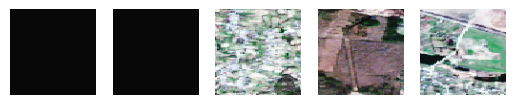

In [ ]:
# Set the directory where the satellite image patches are saved
dir_path = '../../data/PatchesTransferability/sat_patches'

# Get the file paths of the satellite image patches
file_paths = [os.path.join(dir_path, file_name) for file_name in os.listdir(dir_path)]

# Choose a random sample of satellite image patches to visualize
num_samples = 5
sample_paths = random.sample(file_paths, num_samples)

# Load and visualize the sample patches
for i, file_path in enumerate(sample_paths):
    patch = np.load(file_path)
    plt.subplot(1, num_samples, i+1)
    plt.imshow(patch)
    plt.axis('off')


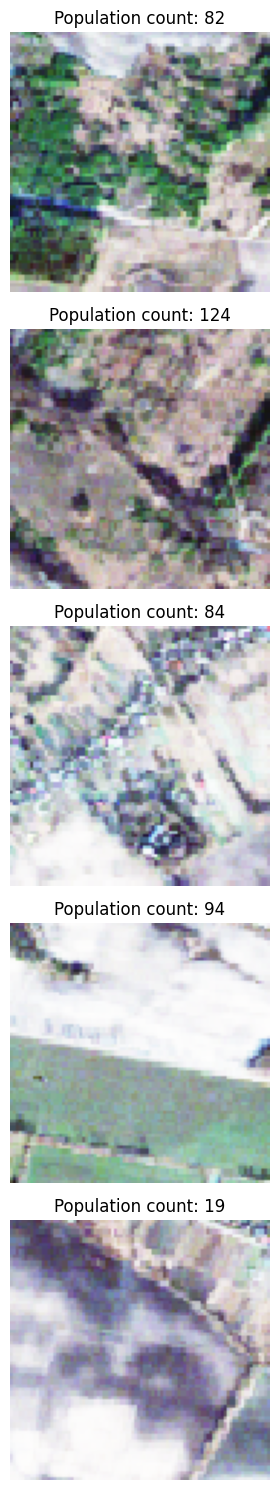

In [ ]:
# Set the directory where the satellite image patches are saved
dir_path = '../../data/PatchesTransferability/sat_patches'

# Get the file paths of the satellite image patches
file_paths = [os.path.join(dir_path, file_name) for file_name in os.listdir(dir_path)]

# Choose a random sample of satellite image patches to visualize
num_samples = 5
sample_paths = random.sample(file_paths, num_samples)

# Load and visualize the sample patches
fig, axs = plt.subplots(nrows=5, figsize=(5, 15))
for i, file_path in enumerate(sample_paths):
    # Load the satellite image patch
    patch = np.load(file_path)
    
    # Load the corresponding population patch
    pop_path = file_path.replace('sat_patches', 'pop_patches').replace('sat_patch', 'pop_patch')
    pop_patch = np.load(pop_path)
    
    # Set the title of the image to the population count
    axs[i].imshow(patch)
    axs[i].set_title(f'Population count: {pop_patch}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()
